Title: RP- Spatial Accessibility of COVID-19 Healthcare Resources in Illinois
---


**Reproduction of**: Rapidly measuring spatial accessibility of COVID-19 healthcare resources: a case study of Illinois, USA

Original study *by* Kang, J. Y., A. Michels, F. Lyu, Shaohua Wang, N. Agbodo, V. L. Freeman, and Shaowen Wang. 2020. Rapidly measuring spatial accessibility of COVID-19 healthcare resources: a case study of Illinois, USA. International Journal of Health Geographics 19 (1):1–17. DOI:[10.1186/s12942-020-00229-x](https://ij-healthgeographics.biomedcentral.com/articles/10.1186/s12942-020-00229-x).

Reproduction Authors: Joe Holler, Kufre Udoh, Derrick Burt, Drew An-Pham, & Spring '21 Middlebury Geog 0323.

Reproduction Materials Available at: [RP-Kang Repository](https://github.com/derrickburt/RP-Kang-Improvements)

Created: `1 Jun 2021`
Revised: `29 Jun 2021`

### Original Data
To perform the ESFCA method, three types of data are required, as follows: (1) road network, (2) population, and (3) hospital information. The road network can be obtained from the [OpenStreetMap Python Library, called OSMNX](https://github.com/gboeing/osmnx). The population data is available on the [American Community Survey](https://data.census.gov/cedsci/deeplinks?url=https%3A%2F%2Ffactfinder.census.gov%2F&tid=GOVSTIMESERIES.CG00ORG01). Lastly, hosptial information is also publically available on the [Homelanad Infrastructure Foundation-Level Data](https://hifld-geoplatform.opendata.arcgis.com/datasets/hospitals?geometry=-94.504%2C40.632%2C-80.980%2C43.486).

### Reproduction Intro

to be written.

### Materials  and Methods
to be written.

### Deviatons from & Improvements to the Original Code

to be written

### Modules
Import necessary libraries to run this model.
See `requirements.txt` for the library versions used for this analysis.

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import osmnx as ox
import re
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
import folium, itertools, os, time, warnings
from IPython.display import display, clear_output

warnings.filterwarnings("ignore")

## Check Directories

Because we have restructured the repository for replication, we need to check our working directory and make necessary adjustments.

In [3]:
os.getcwd()

'/home/jovyan/work/RP-Kang2020/procedure/code'

In [4]:
## Use to set work directory properly
if os.getcwd() == '/home/jovyan/work/RP-Kang2020/procedure/code':
    os.chdir('../../')
if os.getcwd() == '/home/jovyan/work/RP-Kang2020/':
    None 

os.getcwd()

'/home/jovyan/work/RP-Kang2020'

## Load and Visualize Data

### Population and COVID-19 Cases Data by County

*'Cases' column is coming in as 'Unnamed_0' --> easy to rename but this probably should be reportede to the original authors*

In [5]:
overfifty_data = gpd.read_file('./data/raw/public/PopData/Chicago_Tract.shp')
overfifty_data.head()

,GEOID,STATEFP,COUNTYFP,TRACTCE,NAMELSAD,Pop,Unnamed_ 0,NAME,OverFifty,TotalPop,geometry
0,17031010400,17,031,010400,Census Tract 104,5153,1538,"Census Tract 104, Cook County, Illinois",1103,5153,"POLYGON ((-87.66125 42.01288, -87.66125 42.012..."
1,17031010600,17,031,010600,Census Tract 106,6271,438,"Census Tract 106, Cook County, Illinois",1469,6271,"POLYGON ((-87.67059 42.00537, -87.67046 42.005..."
2,17031030200,17,031,030200,Census Tract 302,5444,2075,"Census Tract 302, Cook County, Illinois",2018,5444,"POLYGON ((-87.67062 41.99808, -87.67045 41.998..."
3,17031030300,17,031,030300,Census Tract 303,3464,516,"Census Tract 303, Cook County, Illinois",1097,3464,"POLYGON ((-87.67501 41.99799, -87.67473 41.998..."
4,17031030400,17,031,030400,Census Tract 304,2582,1520,"Census Tract 304, Cook County, Illinois",860,2582,"POLYGON ((-87.67471 41.99076, -87.67440 41.990..."


In [6]:
covid_data = gpd.read_file('./data/raw/public/PopData/Chicago_ZIPCODE.shp')
covid_data['cases'] = covid_data['cases']
covid_data.head()

,ZCTA5CE10,County,State,Join,ZONE,ZONENAME,FIPS,pop,cases,geometry
0,60660,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,43242,78,"POLYGON ((-87.65049 41.99735, -87.65029 41.996..."
1,60640,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,69715,117,"POLYGON ((-87.64645 41.97965, -87.64565 41.978..."
2,60614,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,71308,134,"MULTIPOLYGON (((-87.67703 41.91845, -87.67705 ..."
3,60712,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,12539,42,"MULTIPOLYGON (((-87.76181 42.00465, -87.76156 ..."
4,60076,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,31867,114,"MULTIPOLYGON (((-87.74782 42.01540, -87.74526 ..."


### Hospital Data

Note that 999 is treated as a "NULL"/"NA" so these hospitals are filtered out. This data contains the number of ICU beds and ventilators at each hospital.

In [7]:
hospitals = gpd.read_file('./data/raw/public/HospitalData/Chicago_Hospital_Info.shp')
hospitals.head()

,FID,Hospital,City,ZIP_Code,X,Y,Total_Bed,Adult ICU,Total Vent,geometry
0,2,Methodist Hospital of Chicago,Chicago,60640,-87.671079,41.972800,145,36,12,MULTIPOINT (-87.67108 41.97280)
1,4,Advocate Christ Medical Center,Oak Lawn,60453,-87.732483,41.720281,785,196,64,MULTIPOINT (-87.73248 41.72028)
2,13,Evanston Hospital,Evanston,60201,-87.683288,42.065393,354,89,29,MULTIPOINT (-87.68329 42.06539)
3,24,AMITA Health Adventist Medical Center Hinsdale,Hinsdale,60521,-87.920116,41.805613,261,65,21,MULTIPOINT (-87.92012 41.80561)
4,25,Holy Cross Hospital,Chicago,60629,-87.690841,41.770001,264,66,21,MULTIPOINT (-87.69084 41.77000)


### Generate and Plot Map of Hospitals

In [8]:
m = folium.Map(location=[41.85, -87.65], tiles='cartodbpositron', zoom_start=10)
for i in range(0, len(hospitals)):
    folium.CircleMarker(
      location=[hospitals.iloc[i]['Y'], hospitals.iloc[i]['X']],
      popup="{}{}\n{}{}\n{}{}".format('Hospital Name: ',hospitals.iloc[i]['Hospital'],
                                      'ICU Beds: ',hospitals.iloc[i]['Adult ICU'],
                                      'Ventilators: ', hospitals.iloc[i]['Total Vent']),
      radius=5,
      color='grey',
      fill=True,
      fill_opacity=0.6,
      legend_name = 'Hospitals'
    ).add_to(m)
legend_html =   '''<div style="position: fixed; width: 20%; heigh: auto;
                            bottom: 10px; left: 10px;
                            solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Legend<br>'''

m

### Load and Plot Hexagon Grids (500-meter resolution)

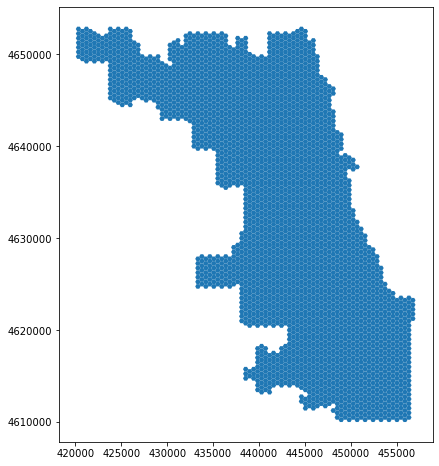

In [9]:
grid_file = gpd.read_file('./data/raw/public/GridFile/Chicago_Grid.shp')
grid_file.plot(figsize=(8,8))

### Load and Plot the Street Network

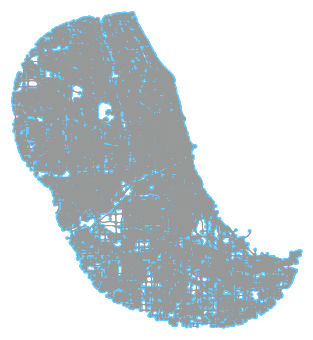

CPU times: user 1min 27s, sys: 1.76 s, total: 1min 29s
Wall time: 1min 29s


(<Figure size 531.74x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0394103250>)

In [10]:
%%time
if not os.path.exists("data/raw/private/Chicago_Network_Buffer.graphml"):
    G = ox.graph_from_place('Chicago', network_type='drive', buffer_dist = 24140.2) # pulling the drive network the first time will take a while
    ox.save_graphml(G, 'raw/private/Chicago_Network_Buffer.graphml')
else:
    G = ox.load_graphml('raw/private/Chicago_Network_Buffer.graphml', node_type=str)
ox.plot_graph(G)

In [11]:
## Get unique counts for each road network
# turn nodes and edges in geodataframes
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# count
print(edges['maxspeed'].value_counts())

25 mph                      4781
30 mph                      3549
35 mph                      3285
40 mph                      2106
45 mph                      1398
                            ... 
[45 mph, 40 mph, 35 mph]       1
[55, 55 mph]                   1
[40 mph, 25 mph, 35 mph]       1
[35 mph, 25 mph, 40 mph]       1
[5 mph, 35 mph]                1
Name: maxspeed, Length: 66, dtype: int64


#### Check OSM edge (road) counts by speed limit

we will compare this to our cleaned network later

## "Helper" Functions

The functions below are needed for our analysis later, let's take a look!

### network_setting

Cleans the OSMNX network to work better with drive-time analysis.

First, we remove all nodes with 0 outdegree because any hospital assigned to such a node would be unreachable from everywhere. Next, we remove small (under 10 node) *strongly connected components* to reduce erroneously small ego-centric networks. Lastly, we ensure that the max speed is set and in the correct units before calculating time.

Args:

* network: OSMNX network for the spatial extent of interest

Returns:

* OSMNX network: cleaned OSMNX network for the spatial extent

In [12]:
def network_setting(network):
    _nodes_removed = len([n for (n, deg) in network.out_degree() if deg ==0])
    network.remove_nodes_from([n for (n, deg) in network.out_degree() if deg ==0])
    for component in list(nx.strongly_connected_components(network)):
        if len(component)<10:
            for node in component:
                _nodes_removed+=1
                network.remove_node(node)
    for u, v, k, data in tqdm(G.edges(data=True, keys=True),position=0):
        if 'maxspeed' in data.keys():
            speed_type = type(data['maxspeed'])
            if (speed_type==str):
                # add in try/except blocks to catch maxspeed formats that don't fit Kang et al's cases
                try:
                    if len(data['maxspeed'].split(','))==2:
                        data['maxspeed_fix']=float(data['maxspeed'].split(',')[0])                  
                    elif data['maxspeed']=='signals':
                        data['maxspeed_fix']=30.0 # drive speed setting as 35 miles
                    else:
                        data['maxspeed_fix']=float(data['maxspeed'].split()[0])
                        print("Warning: the value of", data['maxspeed'], "is being converted to", data['maxspeed_fix'])
                except:
                    data['maxspeed_fix']= 30.0 #miles
            else:
                try:
                    data['maxspeed_fix']=float(data['maxspeed'][0].split()[0])
                except:
                    data['maxspeed_fix']= 30.0 #miles
        else:
            data['maxspeed_fix']= 30.0 #miles
        data['maxspeed_meters'] = data['maxspeed_fix']*26.8223 # convert mile to meter
        data['time'] = float(data['length'])/ data['maxspeed_meters']
    print("Removed {} nodes ({:2.4f}%) from the OSMNX network".format(_nodes_removed, _nodes_removed/float(network.number_of_nodes())))
    print("Number of nodes: {}".format(network.number_of_nodes()))
    print("Number of edges: {}".format(network.number_of_edges()))    
    return(network)

### hospital_setting

Finds the nearest OSMNX node for each hospital.

Args:

* hospital: GeoDataFrame of hospitals
* G: OSMNX network

Returns:

* GeoDataFrame of hospitals with info on nearest OSMNX node

In [13]:
def hospital_setting(hospitals, G):
    hospitals['nearest_osm']=None
    for i in tqdm(hospitals.index, desc="Find the nearest osm from hospitals", position=0):
        hospitals['nearest_osm'][i] = ox.get_nearest_node(G, [hospitals['Y'][i], hospitals['X'][i]], method='euclidean') # find the nearest node from hospital location
    print ('hospital setting is done')
    return(hospitals)

### pop_centroid

Converts geodata to centroids

Args:

* pop_data: a GeodataFrame
* pop_type: a string, either "pop" for general population or "covid" for COVID-19 case data

Returns:

* GeoDataFrame of centroids with population data

In [14]:
# to estimate the centroids of census tract / county
def pop_centroid (pop_data, pop_type):
    pop_data = pop_data.to_crs({'init': 'epsg:4326'})
    if pop_type =="pop":
        pop_data=pop_data[pop_data['OverFifty']>=0] 
    if pop_type =="covid":
        pop_data=pop_data[pop_data['cases']>=0]
    pop_cent = pop_data.centroid # it make the polygon to the point without any other information
    pop_centroid = gpd.GeoDataFrame()
    i = 0
    for point in tqdm(pop_cent, desc='Pop Centroid File Setting', position=0):
        if pop_type== "pop":
            pop = pop_data.iloc[i]['OverFifty']
            code = pop_data.iloc[i]['GEOID']
        if pop_type =="covid":
            pop = pop_data.iloc[i]['cases']
            code = pop_data.iloc[i].ZCTA5CE10
        pop_centroid = pop_centroid.append({'code':code,'pop': pop,'geometry': point}, ignore_index=True)
        i = i+1
    return(pop_centroid)

### djikstra_cca_polygons

Function written by Joe Holler + Derrick Burt. It is a more efficient way to calculate distance-weighted catchment areas for each hospital. The algorithm runs quicker than the original one ("calculate_catchment_area"). It first creaets a dictionary (with a node and its corresponding drive time from the hospital) of all nodes within a 30 minute drive time (using single_cource_dijkstra_path_length function). From here, two more dictionaries are constructed by querying the original one. From this dictionaries, single part convex hulls are created for each drive time interval and appended into a single list (one list with 3 polygon geometries). Within the list, the polygons are differenced from each other to produce three catchment areas.

Args:
* G: cleaned network graph *with node point geometries attached*
* nearest_osm: A unique nearest node ID calculated for a single hospital
* distances: 3 distances (in drive time) to calculate catchment areas from
* distance_unit: unit to calculate (time)

Returns:
* A list of 3 diffrenced (not-overlapping) catchment area polygons (10 min poly, 20 min poly, 30 min poly)

In [15]:
def dijkstra_cca_polygons(G, nearest_osm, distances, distance_unit = "time"):
    
    '''
    
    Before running: must assign point geometries to street nodes
    
    # create point geometries for the entire graph
    for node, data in G.nodes(data=True):
    data['geometry']=Point(data['x'], data['y'])
    
    '''
    
    ## CREATE DICTIONARIES
    # create dictionary of nearest nodes
    nearest_nodes_30 = nx.single_source_dijkstra_path_length(G, nearest_osm, distances[2], distance_unit) # creating the largest graph from which 10 and 20 minute drive times can be extracted from
    
    # extract values within 20 and 10 (respectively) minutes drive times
    nearest_nodes_20 = dict()
    nearest_nodes_10 = dict()
    for key, value in nearest_nodes_30.items():
        if value <= 20:
            nearest_nodes_20[key] = value
        if value <= 10:
            nearest_nodes_10[key] = value
    
    ## CREATE POLYGONS FOR 3 DISTANCE CATEGORIES (10 min, 20 min, 30 min)
    # 30 MIN
    # if the graph already has a geometry attribute with point data,
    # this line will create a GeoPandas GeoDataFrame from the nearest_nodes_30 dictionary
    points_30 = gpd.GeoDataFrame(gpd.GeoSeries(nx.get_node_attributes(G.subgraph(nearest_nodes_30), 'geometry')))

    # this line converts the nearest_nodes_30 dictionary into a Pandas data frame and joins it to points
    # left_index=True and right_index=True are options for merge() to join on the index values
    points_30 = points_30.merge(pd.Series(nearest_nodes_30).to_frame(), left_index=True, right_index=True)

    # re-name the columns and set the geodataframe geometry to the geometry column
    points_30 = points_30.rename(columns={'0_x':'geometry','0_y':'z'}).set_geometry('geometry')

    # create a convex hull polygon from the points
    polygon_30 = gpd.GeoDataFrame(gpd.GeoSeries(points_30.unary_union.convex_hull))
    polygon_30 = polygon_30.rename(columns={0:'geometry'}).set_geometry('geometry')
    
    # 20 MIN
    # select nodes less than or equal to 20
    points_20 = points_30.query("z <= 20")
    
    # create a convex hull polygon from the points
    polygon_20 = gpd.GeoDataFrame(gpd.GeoSeries(points_20.unary_union.convex_hull))
    polygon_20 = polygon_20.rename(columns={0:'geometry'}).set_geometry('geometry')
    
    # 10 MIN
    # select nodes less than or equal to 10
    points_10 = points_30.query("z <= 10")
    
    # create a convex hull polygon from the points
    polygon_10 = gpd.GeoDataFrame(gpd.GeoSeries(points_10.unary_union.convex_hull))
    polygon_10 = polygon_10.rename(columns={0:'geometry'}).set_geometry('geometry')
    
    # Create empty list and append polygons
    polygons = []
    
    # append
    polygons.append(polygon_10)
    polygons.append(polygon_20)
    polygons.append(polygon_30)
    
    for i in reversed(range(1, len(distances))):
        polygons[i] = gpd.overlay(polygons[i], polygons[i-1], how="difference")

    return polygons

### hospital_measure_acc (adjusted to incorporate dijkstra_cca_polygons)

Measures the effect of a single hospital on the surrounding area. (Uses `dijkstra_cca_polygons`)

Args:

* \_thread\_id: int used to keep track of which thread this is
* hospital: Geopandas dataframe with information on a hospital
* pop_data: Geopandas dataframe with population data
* distances: Distances in time to calculate accessibility for
* weights: how to weight the different travel distances

Returns:

* Tuple containing:
    * Int (\_thread\_id)
    * GeoDataFrame of catchment areas with key stats

In [16]:
def hospital_measure_acc (_thread_id, hospital, pop_data, distances, weights):
    # create polygons
    polygons = dijkstra_cca_polygons(G, hospital['nearest_osm'], distances)
    
    # calculate accessibiliy measurements
    num_pops = []
    for j in pop_data.index:
        point = pop_data['geometry'][j]
        for k in range(len(polygons)):
            if len(polygons[k]) > 0: # to exclude the weirdo (convex hull is not polygon)
                if (point.within(polygons[k].iloc[0]["geometry"])):
                    num_pops.append(pop_data['pop'][j]*weights[k])  
    total_pop = sum(num_pops)
    for i in range(len(distances)):
        polygons[i]['time']=distances[i]
        polygons[i]['total_pop']=total_pop
        polygons[i]['hospital_icu_beds'] = float(hospital['Adult ICU'])/polygons[i]['total_pop'] # proportion of # of beds over pops in 10 mins
        polygons[i]['hospital_vents'] = float(hospital['Total Vent'])/polygons[i]['total_pop'] # proportion of # of beds over pops in 10 mins
        polygons[i].crs = { 'init' : 'epsg:4326'}
        polygons[i] = polygons[i].to_crs({'init':'epsg:32616'})
    print('\rCatchment for hospital {:4.0f} complete'.format(_thread_id), end="")
    return(_thread_id, [ polygon.copy(deep=True) for polygon in polygons ]) 

### measure_acc_par

Parallel implementation of accessibility measurement.

Args:

* hospitals: Geodataframe of hospitals
* pop_data: Geodataframe containing population data
* network: OSMNX street network
* distances: list of distances to calculate catchments for
* weights: list of floats to apply to different catchments
* num\_proc: number of processors to use.

Returns:

* Geodataframe of catchments with accessibility statistics calculated

In [17]:
def hospital_acc_unpacker(args):
    return hospital_measure_acc(*args)

def measure_acc_par (hospitals, pop_data, network, distances, weights, num_proc = 4):
    catchments = []
    for distance in distances:
        catchments.append(gpd.GeoDataFrame())
    pool = mp.Pool(processes = num_proc)
    hospital_list = [ hospitals.iloc[i] for i in range(len(hospitals)) ]
    results = pool.map(hospital_acc_unpacker, zip(range(len(hospital_list)), hospital_list, itertools.repeat(pop_data), itertools.repeat(distances), itertools.repeat(weights)))
    pool.close()
    results.sort()
    results = [ r[1] for r in results ]
    for i in range(len(results)):
        for j in range(len(distances)):
            catchments[j] = catchments[j].append(results[i][j], sort=False)
    return catchments

### overlap_calc

Calculates and aggregates accessibility statistics for one catchment on our grid file.

Args:

* \_id: thread ID
* poly: GeoDataFrame representing a catchment area
* grid_file: a GeoDataFrame representing our grids
* weight: the weight to applied for a given catchment
* service_type: the service we are calculating for: ICU beds or ventilators

Returns:

* Tuple containing:
    * thread ID
    * Counter object (dictionary for numbers) with aggregated stats by grid ID number

In [18]:
from collections import Counter
def overlap_calc(_id, poly, grid_file, weight, service_type):
    value_dict = Counter()
    if type(poly.iloc[0][service_type])!=type(None):           
        value = float(poly[service_type])*weight
        intersect = gpd.overlay(grid_file, poly, how='intersection')
        intersect['overlapped']= intersect.area
        intersect['percent'] = intersect['overlapped']/intersect['area']
        intersect=intersect[intersect['percent']>=0.5]
        intersect_region = intersect['id']
        for intersect_id in intersect_region:
            try:
                value_dict[intersect_id] +=value
            except:
                value_dict[intersect_id] = value
    return(_id, value_dict)

def overlap_calc_unpacker(args):
    return overlap_calc(*args)

### overlapping_function

Calculates how all catchment areas overlap with and affect the accessibility of each grid in our grid file.

Args:

* grid_file: GeoDataFrame of our grid
* catchments: GeoDataFrame of our catchments
* service_type: the kind of care being provided (ICU beds vs. ventilators)
* weights: the weight to apply to each service type
* num\_proc: the number of processors

Returns:

* Geodataframe - grid\_file with calculated stats

In [19]:
def overlapping_function (grid_file, catchments, service_type, weights, num_proc = 4):
    grid_file[service_type]=0
    pool = mp.Pool(processes = num_proc)
    acc_list = []
    for i in range(len(catchments)):
        acc_list.extend([ catchments[i][j:j+1] for j in range(len(catchments[i])) ])
    acc_weights = []
    for i in range(len(catchments)):
        acc_weights.extend( [weights[i]]*len(catchments[i]) )
    results = pool.map(overlap_calc_unpacker, zip(range(len(acc_list)), acc_list, itertools.repeat(grid_file), acc_weights, itertools.repeat(service_type)))
    pool.close()
    results.sort()
    results = [ r[1] for r in results ]
    service_values = results[0]
    for result in results[1:]:
        service_values+=result
    for intersect_id, value in service_values.items():
        grid_file.loc[grid_file['id']==intersect_id, service_type] += value
    return(grid_file)

### normalization

Normalizes our result (Geodataframe) for a given resource (res).

In [20]:
def normalization (result, res):
    result[res]=(result[res]-min(result[res]))/(max(result[res])-min(result[res]))
    return result

### file_import

Imports all files we need to run our code and pulls the Illinois network from OSMNX if it is not present (will take a while). 

**NOTE:** even if we calculate accessibility for just Chicago, we want to use the Illinois network (or at least we should not use the Chicago network) because using the Chicago network will result in hospitals near but outside of Chicago having an infinite distance (unreachable because roads do not extend past Chicago).

Args:

* pop_type: population type, either "pop" for general population or "covid" for COVID-19 cases
* region: the region to use for our hospital and grid file ("Chicago" or "Illinois")

Returns:

* G: OSMNX network
* hospitals: Geodataframe of hospitals
* grid_file: Geodataframe of grids
* pop_data: Geodataframe of population

In [21]:
def output_map(output_grid, base_map, hospitals, resource):
    ax=output_grid.plot(column=resource, cmap='PuBuGn',figsize=(18,12), legend=True, zorder=1)
    # next two lines set bounds for our x- and y-axes because it looks like there's a weird 
    # point at the bottom left of the map that's messing up our frame (Maja)
    ax.set_xlim([314000, 370000])
    ax.set_ylim([540000, 616000])
    base_map.plot(ax=ax, facecolor="none", edgecolor='gray', lw=0.1)
    hospitals.plot(ax=ax, markersize=10, zorder=1, c='blue')

### Run the model

Below you can customize the input of the model:

* Processor - the number of processors to use
* Region - the spatial extent of the measure
* Population - the population to calculate the measure for
* Resource - the hospital resource of interest

In [22]:
import ipywidgets
from IPython.display import display

processor_dropdown = ipywidgets.Dropdown( options=[("1", 1), ("2", 2), ("3", 3), ("4", 4)],
    value = 4, description = "Processor: ")

place_dropdown = ipywidgets.Dropdown( options=[("Chicago", "Chicago"), ("Illinois","Illinois")],
    value = "Chicago", description = "Region: ")

population_dropdown = ipywidgets.Dropdown( options=[("Population at Risk", "pop"), ("COVID-19 Patients", "covid") ],
    value = "pop", description = "Population: ")

resource_dropdown = ipywidgets.Dropdown( options=[("ICU Beds", "hospital_icu_beds"), ("Ventilators", "hospital_vents") ],
    value = "hospital_icu_beds", description = "Resource: ")
display(processor_dropdown,place_dropdown,population_dropdown,resource_dropdown)

Dropdown(description='Processor: ', index=3, options=(('1', 1), ('2', 2), ('3', 3), ('4', 4)), value=4)

Dropdown(description='Region: ', options=(('Chicago', 'Chicago'), ('Illinois', 'Illinois')), value='Chicago')

Dropdown(description='Population: ', options=(('Population at Risk', 'pop'), ('COVID-19 Patients', 'covid')), …

Dropdown(description='Resource: ', options=(('ICU Beds', 'hospital_icu_beds'), ('Ventilators', 'hospital_vents…

In [23]:
%%time
# G, hospitals, grid_file, pop_data = file_import (population_dropdown.value, place_dropdown.value)
G = network_setting(G)
# Create point geometries for the entire graph (ESSENTIAL FOR CALCULATING CATCHMENT AREAS W DIJKSTRA METHOD)
for node, data in G.nodes(data=True):
    data['geometry']=Point(data['x'], data['y'])
# modify code to react to processor drop_down (got rid of file_import function)
if population_dropdown.value == "pop":
    pop_data = pop_centroid(overfifty_data, population_dropdown.value)
elif population_dropdown.value == "covid":
    pop_data = pop_centroid(covid_data, population_dropdown.value)
hospitals = hospital_setting(hospitals, G)
distances=[10,20,30] # distances in travel time
weights=[1.0, 0.68, 0.22] # weights where weights[0] is applied to distances[0]
# Other weighting options representing different distance decays
# weights1, weights2, weights3 = [1.0, 0.42, 0.09], [1.0, 0.75, 0.5], [1.0, 0.5, 0.1]
resources = ["hospital_icu_beds", "hospital_vents"] # resources

  1%|▏         | 5357/384050 [00:00<00:15, 23929.23it/s]

  3%|▎         | 9955/384050 [00:00<00:13, 27893.40it/s]

40.0

  5%|▌         | 19208/384050 [00:00<00:10, 33991.32it/s]

is being converted to 25.0

  8%|▊         | 29014/384050 [00:00<00:09, 38641.03it/s]

 is being converted to 25.0

  9%|▊         | 33084/384050 [00:00<00:11, 30872.79it/s]

35 mph is being converted to 35.0

 11%|█▏        | 43574/384050 [00:01<00:08, 37974.59it/s]

 55.0

 12%|█▏        | 47882/384050 [00:01<00:10, 30910.16it/s]

is being converted to 45.0

 15%|█▍        | 57022/384050 [00:01<00:09, 33732.12it/s]

 17%|█▋        | 65503/384050 [00:01<00:09, 34862.95it/s]

 30 mph is being converted to 30.0

 18%|█▊        | 69301/384050 [00:01<00:09, 32514.27it/s]

 is being converted to 25.0

 20%|█▉        | 76510/384050 [00:02<00:09, 32419.74it/s]

 25 mph is being converted to 25.0

 22%|██▏       | 85896/384050 [00:02<00:07, 38462.34it/s]

 24%|██▍       | 93783/384050 [00:02<00:07, 36878.71it/s]

 30 mph is being converted to 30.0

 26%|██▋       | 101055/384050 [00:02<00:08, 32857.62it/s]

 25 mph is being converted to 25.0

 28%|██▊       | 107786/384050 [00:03<00:08, 31703.22it/s]

 25 mph is being converted to 25.0

 29%|██▉       | 111023/384050 [00:03<00:09, 29036.04it/s]

is being converted to 30.0

 31%|███       | 118317/384050 [00:03<00:08, 32153.82it/s]

 20.0

 33%|███▎      | 125492/384050 [00:03<00:07, 33540.20it/s]

 30 mph is being converted to 30.0

 35%|███▍      | 132993/384050 [00:03<00:07, 35092.52it/s]

 60.0

 37%|███▋      | 140820/384050 [00:04<00:06, 35477.17it/s]

 35 mph is being converted to 35.0

 39%|███▉      | 150881/384050 [00:04<00:06, 38813.24it/s]

 42%|████▏     | 160344/384050 [00:04<00:05, 41421.44it/s]

 25 mph is being converted to 25.0

 44%|████▍     | 169749/384050 [00:04<00:04, 44010.79it/s]

20.0

 45%|████▌     | 174253/384050 [00:04<00:06, 34701.20it/s]

 45.0

 48%|████▊     | 182723/384050 [00:05<00:05, 36609.73it/s]

 50%|████▉     | 190416/384050 [00:05<00:05, 35013.78it/s]

35.0


 52%|█████▏    | 198427/384050 [00:05<00:05, 35834.46it/s]

 54%|█████▍    | 207136/384050 [00:05<00:04, 39390.64it/s]

 25 mph is being converted to 25.0

 55%|█████▍    | 211162/384050 [00:05<00:04, 39548.77it/s]

45.0

 57%|█████▋    | 218857/384050 [00:06<00:04, 35222.86it/s]

25 mph is being converted to 25.0

 59%|█████▉    | 226000/384050 [00:06<00:04, 33491.53it/s]

is being converted to 25.0

 61%|██████    | 234011/384050 [00:06<00:04, 36315.50it/s]

25.0

 63%|██████▎   | 242478/384050 [00:06<00:03, 37534.65it/s]

 45 mph is being converted to 45.0

 65%|██████▌   | 250679/384050 [00:06<00:03, 37323.82it/s]

 30.0

 67%|██████▋   | 258319/384050 [00:07<00:03, 36313.55it/s]

is being converted to 45.0

 69%|██████▉   | 265433/384050 [00:07<00:03, 33420.01it/s]

40 mph is being converted to 40.0

 70%|██████▉   | 268829/384050 [00:07<00:03, 31530.80it/s]

 is being converted to 45.0

 72%|███████▏  | 275832/384050 [00:07<00:03, 32966.17it/s]

 is being converted to 35.0

 74%|███████▎  | 282654/384050 [00:07<00:03, 33135.64it/s]

 is being converted to 30.0

 75%|███████▌  | 289238/384050 [00:08<00:02, 31834.90it/s]

55.0

 77%|███████▋  | 296540/384050 [00:08<00:03, 28677.00it/s]

35.0

 79%|███████▉  | 302447/384050 [00:08<00:02, 27423.97it/s]

is being converted to 25.0

 79%|███████▉  | 305271/384050 [00:08<00:03, 25157.80it/s]

 30 mph is being converted to 30.0

 81%|████████  | 310384/384050 [00:09<00:03, 22218.67it/s]

 is being converted to 40.0

 82%|████████▏ | 313359/384050 [00:09<00:02, 24030.84it/s]

is being converted to 45.0

 83%|████████▎ | 318292/384050 [00:09<00:03, 21847.07it/s]

 85%|████████▍ | 324835/384050 [00:09<00:02, 25296.37it/s]

 is being converted to 30.0

 87%|████████▋ | 332828/384050 [00:09<00:01, 29850.17it/s]

 89%|████████▉ | 341772/384050 [00:10<00:01, 34019.52it/s]

45.0


 91%|█████████ | 349891/384050 [00:10<00:00, 34546.96it/s]

 94%|█████████▎| 359552/384050 [00:10<00:00, 37582.13it/s]

 is being converted to 30.0

 96%|█████████▋| 370606/384050 [00:10<00:00, 44345.82it/s]

 is being converted to 30.0

 98%|█████████▊| 375284/384050 [00:10<00:00, 40103.00it/s]

55.0

100%|█████████▉| 383384/384050 [00:11<00:00, 35310.27it/s]

 35 mph is being converted to 35.0


100%|██████████| 384050/384050 [00:11<00:00, 34466.36it/s]


Removed 275 nodes (0.0019%) from the OSMNX network
Number of nodes: 142045
Number of edges: 384050


Find the nearest osm from hospitals: 100%|██████████| 66/66 [00:25<00:00,  2.54it/s]

hospital setting is done
CPU times: user 45.3 s, sys: 5.73 s, total: 51 s
Wall time: 46.5 s


#### Check OSM Network

compare to earlier speed counts

In [24]:
## Get unique counts for each road network
# turn nodes and edges in geodataframes
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# count
print(edges['maxspeed_fix'].value_counts())

30.0     369718
25.0       4826
35.0       3300
40.0       2196
45.0       1491
20.0       1159
55.0        617
60.0        276
50.0        210
70.0         87
15.0         82
65.0         42
10.0         38
100.0         4
5.0           4
Name: maxspeed_fix, dtype: int64


In [25]:
%%time
catchments = measure_acc_par(hospitals, pop_data, G, distances, weights, num_proc=processor_dropdown.value)

Catchment for hospital   65 completeCPU times: user 2.92 s, sys: 453 ms, total: 3.37 s
Wall time: 1min 10s


In [26]:
%%time
for j in range(len(catchments)):
    catchments[j] = catchments[j][catchments[j][resource_dropdown.value]!=float('inf')]
result=overlapping_function (grid_file, catchments, resource_dropdown.value, weights, num_proc=processor_dropdown.value)

CPU times: user 9.21 s, sys: 276 ms, total: 9.49 s
Wall time: 45 s


In [27]:
%%time
result = normalization (result, resource_dropdown.value)

CPU times: user 2.32 ms, sys: 15 µs, total: 2.34 ms
Wall time: 2.13 ms


In [28]:
result.head()

,left,top,right,bottom,id,area,geometry,hospital_icu_beds
0,440843.416087,4.638515e+06,441420.766356,4.638015e+06,4158,216661.173,"POLYGON ((440843.416 4638265.403, 440987.754 4...",0.859660
1,440843.416087,4.638015e+06,441420.766356,4.637515e+06,4159,216661.168,"POLYGON ((440843.416 4637765.403, 440987.754 4...",0.859660
2,440843.416087,4.639515e+06,441420.766356,4.639015e+06,4156,216661.169,"POLYGON ((440843.416 4639265.403, 440987.754 4...",0.870759
3,440843.416087,4.639015e+06,441420.766356,4.638515e+06,4157,216661.171,"POLYGON ((440843.416 4638765.403, 440987.754 4...",0.867218
4,440843.416087,4.640515e+06,441420.766356,4.640015e+06,4154,216661.171,"POLYGON ((440843.416 4640265.403, 440987.754 4...",0.914352


### Results & Discussion

to be written.

Continuous Accessibility Outputs

CPU times: user 1.92 s, sys: 520 ms, total: 2.44 s
Wall time: 1.85 s


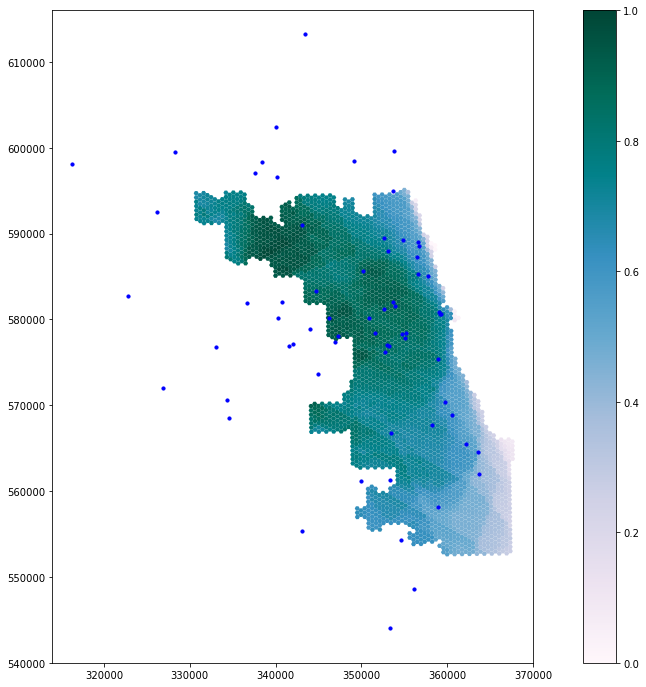

In [29]:
%%time
hospitals = hospitals.to_crs({'init': 'epsg:26971'})
result = result.to_crs({'init': 'epsg:26971'})
output_map(result, pop_data, hospitals, resource_dropdown.value)

Classified Accessibility Outputs

### Comparison with Original Results

In [30]:
from scipy import stats

In [31]:
# import study results to compare
## PROBLEM: doesn't specify whether thesee values refer to COVID or AT RISK Population .... 
fp = 'data/derived/public/Chicago_ACC.shp'
og_result = gpd.read_file(fp)

og_result.head()

,id,hospital_i,hospital_v,geometry
0,4158,0.844249,0.843439,"POLYGON ((-87.71312 41.89411, -87.71140 41.896..."
1,4159,0.843600,0.843031,"POLYGON ((-87.71307 41.88961, -87.71135 41.891..."
2,4156,0.906094,0.904699,"POLYGON ((-87.71322 41.90312, -87.71150 41.905..."
3,4157,0.877197,0.876503,"POLYGON ((-87.71317 41.89861, -87.71145 41.900..."
4,4154,0.911424,0.910002,"POLYGON ((-87.71332 41.91212, -87.71160 41.914..."


In [32]:
check = gpd.read_file('data/derived/public/ACC_Chicago_2018_ZIP_POP.shp')
check.head()

,left,top,right,bottom,id,area,value,geometry
0,440843.416087,4.638515e+06,441420.766356,4.638015e+06,4158,216661.173,0.004850,"POLYGON ((-87.71312 41.89411, -87.71140 41.896..."
1,440843.416087,4.638015e+06,441420.766356,4.637515e+06,4159,216661.168,0.004907,"POLYGON ((-87.71307 41.88961, -87.71135 41.891..."
2,440843.416087,4.639515e+06,441420.766356,4.639015e+06,4156,216661.169,0.004902,"POLYGON ((-87.71322 41.90312, -87.71150 41.905..."
3,440843.416087,4.639015e+06,441420.766356,4.638515e+06,4157,216661.171,0.004926,"POLYGON ((-87.71317 41.89861, -87.71145 41.900..."
4,440843.416087,4.640515e+06,441420.766356,4.640015e+06,4154,216661.171,0.004902,"POLYGON ((-87.71332 41.91212, -87.71160 41.914..."


In [33]:
# define variables to be used in plotting
og_icu = og_result['hospital_i']
og_vents = og_result['hospital_v']
if (population_dropdown.value == "pop") & (resource_dropdown == "hospital_icu_beds"):
    rp_atrisk_icu = result['hospital_icu_beds']
elif (population_dropdown.value == "pop") & (resource_dropdown == "hospital_vents"):
    rp_atrisk_vents = result['hospital_vents']
elif (population_dropdown.value == "covid") & (resource_dropdown == "hospital_icu_beds"):
    rp_covid_icu = result['hospital_icu_beds'] 
elif (population_dropdown.value == "covid") & (resource_dropdown == "hospital_vents"):
    rp_covid_vents = result['hospital_vents']

In [34]:
## The authord only provide the results for the covid accessibility measurements
# calculate spearman rho value
icu_rho = stats.spearmanr(rp_covid_icu, og_icu)
vents_rho = stats.spearmanr(rp_covid_vents, og_vents)

NameError: name 'rp_covid_icu' is not defined

In [ ]:
print("icu rho:", icu_rho)
print("vents rho:", vents_rho)

In [ ]:
# create subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,4));

# ax11.scatter(rp_atrisk_icu, og_icu, s=1)
# ax11.set_xlabel("At Risk ICU", labelpad =5)
# ax12.scatter(rp_atrisk_vents, og_vents, s=1)
# ax12.set_xlabel("At Risk Vents", labelpad =5)
axs[0].scatter(rp_covid_icu, og_icu, s=1.5)
axs[0].set_xlabel("Covid ICU - Reproduction", labelpad=5)
axs[0].set_ylabel("Covid ICU - Original", labelpad =5)
axs[0].text(.45, .08, "correlation=0.8937208251590388, pvalue=0.0", fontsize=8)
axs[1].scatter(rp_covid_vents, og_vents, s=1.5)
axs[1].set_xlabel("Covid Vents - Reproduction", labelpad =5)
axs[1].set_ylabel("Covid Vents - Original", labelpad =5)
axs[1].text(.45, .08, "correlation=0.8933951605501842, pvalue=0.0", fontsize=8)

### Conclusion

to be written.

### References

Luo, W., & Qi, Y. (2009). An enhanced two-step floating catchment area (E2SFCA) method for measuring spatial accessibility to primary care physicians. Health & place, 15(4), 1100-1107.